In [1]:
# import module
import tensorflow as tf

import numpy as np
import os
import io
import time
import matplotlib.pyplot as plt

PROBLEM = "TSP10"


#Define Token
START_ID = 0 #시퀀스 시작 토큰 ID
PAD_ID = 1   #시퀀스 공백 토큰 ID
END_ID = 2   #시퀀스 종결 토큰 ID

PARAM = {"TSP5": ["./data/tsp5_random.txt", 5, 5, False],
        "TSP10": ["./data/tsp10_random.txt", 10, 10, False],
        "TSP50": ["./data/tsp50_a3_random.txt", 50, 50, False],
        "CONVEX5": ["./data/convex_hull_5_test.txt", 5, 7, True]
        }

#DATA_PATH: 데이터 파일 디렉토리
#ENC_MAX_STEP: 입력 길이
#DEC_MAX_STEP: 출력 길이
#USE_END_TOKEN: 종결토큰 사용 여부
DATA_PATH, ENC_MAX_STEP, DEC_MAX_STEP, USE_END_TOKEN = PARAM[PROBLEM]


PREFIX = DATA_PATH[7:-4]
#Label + End Token 최대 길이 

BATCH_SIZE = 512
EPOCHS = 250

NUM_LAYERS = 3
UNITS = 256
NUM_HEADS = 8

# Positional Encoding 쓰게 할 것인가?
USE_POSITIONAL_ENCODING = True

LEARNING_RATE = 0.001
BEAM_WIDTH = 4
OUTPUT_STD = None
DROPOUT_RATE = 0.0
#graident Clipping 파라미터
CLIPPING_VALUE = None
TRAIN_DATA_RATIO = 0.9

In [2]:
#데이터 로드 및 배치 생성기 유틸리티

def load_Dataset(data_path, input_step, output_step, with_end_token = True):
    inputs = []
    inputs_masks = []
    inputs_lengths = []
    labels = []
    labels_masks = []
    labels_lengths = []
    ENC_MAX_STEP = input_step
    DEC_MAX_STEP = output_step
    with open(data_path, 'r') as file:
        line = file.readline()
        while line :
            one_input = np.zeros([ENC_MAX_STEP, 2], dtype=np.float32)
            one_input_mask = np.zeros([ENC_MAX_STEP], dtype=int)
            line = line.split()
            length = 0
            i = 0
            while(line[i] != 'output'):
                one_input[length][0] = float(line[i])
                one_input[length][1] = float(line[i + 1])
                one_input_mask[length] = 1
                i += 2
                length += 1
            inputs.append(one_input)
            inputs_masks.append(one_input_mask)
            inputs_lengths.append(length)
            i += 1
            one_label = np.ones([DEC_MAX_STEP], dtype = int) * -1
            one_label_mask = np.zeros([DEC_MAX_STEP], dtype = int)
            length = 0
            while (i < len(line)):
                # 0 = start_id, 1 = pad_id, 2 = end_id
                one_label[length] = int(line[i])
                one_label_mask[length] = 1
                length += 1
                i += 1
            if with_end_token:
                one_label[length] = 0  #end token
                one_label_mask[length] = 1
                length += 1

            labels.append(one_label)
            labels_masks.append(one_label_mask)
            labels_lengths.append(length)
            line = file.readline()

    inputs = np.stack(inputs)
    inputs_masks = np.stack(inputs_masks)
    inputs_lengths = np.array(inputs_lengths)
    labels = np.stack(labels)
    labels_masks = np.stack(labels_masks)
    labels_lengths = np.array(labels_lengths)

    return inputs, labels
    

class Batcher:
    def __init__(self, x, y, randomize = False):
        self.test_x = x
        self.test_y = y
        self.test_random_idx = None
        self.test_random = randomize
    
    def get_batch(self, batch_size):
        def shuffle_idx(x):
            if (self.test_random):
                np.random.shuffle(x)
        
        if (self.test_random_idx is None):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp = []
        targ = []
        while (batch_size > self.test_random_idx.shape[0]):
            inp.append(self.test_x[self.test_random_idx])
            targ.append(self.test_y[self.test_random_idx])
            batch_size -= self.test_random_idx.shape[0]
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        inp.append(self.test_x[self.test_random_idx[:batch_size]])
        targ.append(self.test_y[self.test_random_idx[:batch_size]])
        if (self.test_random_idx.shape[0] - batch_size == 0):
            self.test_random_idx = np.arange(self.test_x.shape[0])
            shuffle_idx(self.test_random_idx)
        else :
            self.test_random_idx = self.test_random_idx[batch_size:]
        inp = np.concatenate(inp, axis = 0)
        targ = np.concatenate(targ, axis = 0)
        return inp, targ
    def reset_random(self):
        self.test_random_idx = None
        

In [3]:
inputs, labels = load_Dataset(DATA_PATH, ENC_MAX_STEP, DEC_MAX_STEP, with_end_token=USE_END_TOKEN)

print("예제 1번 점 집합")
print(inputs[:1])

print("예제 1번 정답")
print(labels[:1])



cut = int(inputs.shape[0] * TRAIN_DATA_RATIO)

train_inputs = inputs[:cut]
train_labels = labels[:cut]

val_inputs   = inputs[cut:]
val_labels   = labels[cut:]

train_batcher = Batcher(train_inputs, train_labels, randomize=True)
val_batcher   = Batcher(val_inputs, val_labels, randomize = False)

#if TEST_STEP == None:
#    TEST_STEP = max([val_inputs.shape[0] // BATCH_SIZE, 1])


STEPS_PER_EPOCH = cut//BATCH_SIZE

예제 1번 점 집합
[[[0.59764034 0.81147295]
  [0.37839255 0.1881658 ]
  [0.44284964 0.29181516]
  [0.36377418 0.59624463]
  [0.95521194 0.94703186]]]
예제 1번 정답
[[2 3 5 1 4]]


# Positional Encoding

(1, 2048, 512)


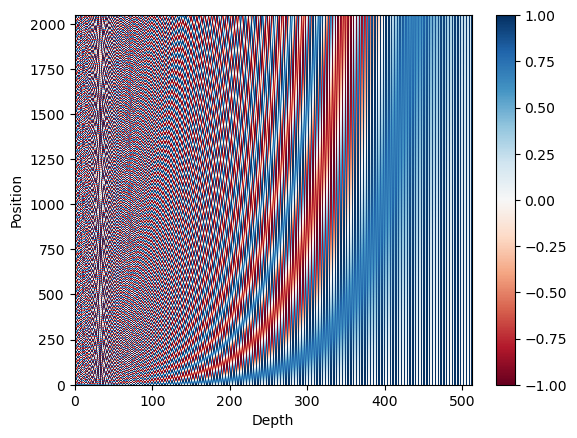

In [4]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates


def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)


n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
#pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
#pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
#pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()



# Make Padding Mask

In [5]:
def create_padding_mask(seq):
  # 0: it is not padding (x >= 0)
  # 1: it is padding (x < 0)
  seq = tf.cast(tf.math.less(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)


x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, -1], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 1.]]],


       [[[0., 0., 0., 0., 0.]]]], dtype=float32)>

# Make look ahead mask

In [6]:
def create_look_ahead_mask(size):
  # 0: Not a future thing
  # 1: It is future thing
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

# Scaled_dot_product attention

In [7]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

# Mutli Head Attention

In [8]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

# Pointer

In [9]:
class Pointer(tf.keras.layers.Layer):
  def __init__(self, d_model, return_as_logit=True):
    super(Pointer, self).__init__()
    self.d_model = d_model

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)

    self.return_as_logit = return_as_logit

  def call(self, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    
    #q = tf.expand_dims(q, axis=1)
    #k = tf.expand_dims(k, axis=1)

    
    
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
      scaled_attention_logits += (mask * -1e9)
    
    if self.return_as_logit:
      return scaled_attention_logits

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    return attention_weights

# Point-wise Feed Forward

In [10]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

# Encoder Layer (Residual Block)

In [11]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

# Decoder Layer (Residual Block)

In [12]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

# Encoder

In [13]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               maximum_position_encoding, rate=0.1,
               use_positional_encoding=True):
    # num_layer: the number of Residual blocks
    # d_model: dimension of hidden state
    # num_head: the number of multi-head
    # dff: dimension of feed-forward network
    # maximum_position_encoding: yes, It is what it say.
    #                    It is better to be same as max sequence length
    # rate: dropout rate
    
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.use_positional_encoding = use_positional_encoding
    
    self.embedding = tf.keras.layers.Dense(self.d_model)
    
    if self.use_positional_encoding:
      self.pos_encoding = positional_encoding(maximum_position_encoding,
                                              self.d_model)

    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    if self.use_positional_encoding:
      x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

# Decoder

In [14]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff,
               maximum_position_encoding, rate=0.1,
               use_positional_encoding=True):
    # num_layer: the number of Residual blocks
    # d_model: dimension of hidden state
    # num_head: the number of multi-head
    # dff: dimension of feed-forward network
    # maximum_position_encoding: yes, It is what it say.
    #                    It is better to be same as max sequence length
    # rate: dropout rate
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.use_positional_encoding = use_positional_encoding

    self.embedding = tf.keras.layers.Dense(d_model)
    
    
    if self.use_positional_encoding:
      self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
    self.pointer = Pointer(d_model, return_as_logit=True)
    
  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    if self.use_positional_encoding:
      x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    x = self.pointer(enc_output, x, padding_mask)
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

# Transformer ptr-net


In [15]:
class PointerNetwork:
    def __init__(self, num_layers=3, unit=512, num_heads=8, batch_size=256,
                 enc_max_step=50,
                 dec_max_step=50,
                 learning_rate = 0.001,
                 output_std = None,
                 dropout_rate = 0.0,
                 use_end_token = True,
                 use_positional_encoding = True):
        self.encoder = Encoder(num_layers, unit, num_heads, unit,
                               enc_max_step, dropout_rate,
                               use_positional_encoding)
        self.decoder = Decoder(num_layers, unit, num_heads, unit,
                               dec_max_step, dropout_rate,
                               use_positional_encoding)
        #Loss Function에 사용할 함수로 Cross Entropy 사용
        self.loss_object = tf.keras.losses.CategoricalCrossentropy(
                                      from_logits=True, reduction='none') 
        #학습 Optimizer 설정. Adam 사용
        self.optimizer = tf.keras.optimizers.Adam(learning_rate)
        
        self.use_end_token = use_end_token
        
        #End token의 Key token 생성
        if self.use_end_token == False:
            output_std = 0
        #make end token embedding for pointing
        if (output_std is None):
            output_std = 0.0125 * np.sqrt(256 / unit)
        self.end_token_outputs = tf.Variable(np.random.normal(0, output_std, [1, 1, unit]), dtype = np.float32)
            
        #token 좌표 테이블
        #디코더의 매 스텝마다 출력이 나오면, 해당 출력에 해당하는 점의 좌표 값이 
        #다음 스텝으로 입력으로 들어가게 되는데
        #시작 토큰(0)이나 다른 토큰(1, 2)들이 나왔을 때, 다음 입력으로 들어갈 (x, y) 좌표 테이블이다.
        #임의로 설정 가능하며, (0 , 0)으로 설정함
        #token_table = [[begin_token, end_token, pad_token]]
        #begin_token = end_token = pad_token = (0, 0)
        self.token_table = tf.Variable(np.zeros([1, 3, 2]), dtype = np.float32)
        
        #Checkpoint 파라미터 전달용 dict
        self.model = {}
        self.model['encoder'] = self.encoder
        self.model['decoder'] = self.decoder
        self.model['optimizer'] = self.optimizer
        self.model['end_token_outputs'] = self.end_token_outputs
        
    def get_model(self):
        return self.model
    
    #정답 real(정수값)와 스코어 pred(실수 점수)가 들어오면 두 값의 loss를 구함 
    def loss_function(self, real, pred):
        #real.shape = (BATCH_SIZE, DEC_MAX_STEP)
        #pred.shape = (BATCH_SIZE, DEC_MAX_STEP, 1 + ENC_MAX_STEP, 1)
        
        #real_onehot.shape = (BATCH_SIZE, DEC_MAX_STEP, 1 + ENC_MAX_STEP)
        real_onehot = tf.one_hot(real, pred.shape[-2], on_value = 1.0)
        
        #loss_ = (BATCH_SIZE, DEC_MAX_STEP)
        loss_ = self.loss_object(real_onehot, pred)
        
        #real(정답)에서 padding(-1)에 해당하는 부분은 제외함
        #mask = (BATCH_SIZE, DEC_MAX_STEP)
        mask = tf.math.logical_not(tf.math.equal(real, -1))
        
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return tf.reduce_sum(loss_) / tf.reduce_sum(mask) , loss_, mask
    
    #Teacher forcing
    #학습의 용이를 위하여 이전 스텝의 정답(targ[t-1])을 이번 스텝의 입력으로 넣는 학습법
    def teacher_forcing_run(self, inp, targ, inp_mask=None):
        #inp:  [BATCH_SIZE, ENC_MAX_STEP, 2]
        #targ: [BATCH_SIZE, DEC_MAX_STEP]
      
        #local batch size
        local_bsz = inp.shape[0]
        
        #padding mask
        targ_mask = create_padding_mask(targ)
        
        #look_ahead_mask
        look_ahead_mask = create_look_ahead_mask(targ.shape[1])
        look_ahead_mask = tf.maximum(targ_mask, look_ahead_mask)

        #Encoder 출력 파트 
        #enc_output.shape = (BATCH_SIZE, ENC_MAX_STEP, hidden_size)
        enc_output = self.encoder(inp, training=True, mask=inp_mask)
        
        

        enc_output = tf.concat([tf.tile(self.end_token_outputs, [local_bsz, 1, 1]),
                            enc_output], 1)
        
        # token table에 대한 자세한 설명은 __init__ 함수 참고
        #tiled_token_table = (BATCH_SIZE, 3, 2)
        tiled_token_table = tf.tile(self.token_table, [local_bsz, 1, 1])
        #enc_table = (BATCH_SIZE, 3 + ENC_MAX_STEP, 2)
        #[token_table | input_table]
        enc_table = tf.concat([tiled_token_table, inp], 1)

        #시작 입력 (시작 토큰)
        #dec_input = (BATCH_SIZE, 1)
        dec_input = tf.expand_dims([START_ID] * local_bsz, 1)
        
        #teacher forcing 입력 설계
        #매 스텝의 입력은 다음과 같이 처리된다.
        #[start_token, first_label, ... last_label, pad_token, ...]
        
        #dec_input = (BATCH_SIZE, DEC_MAX_STEP), 정수형
        dec_input = tf.concat([dec_input, tf.cast(targ[:, :-1] + END_ID, dtype=np.int32)], 1)
        #dec_input = (BATCH_SIZE, DEC_MAX_STEP, 1)
        dec_input = tf.expand_dims(dec_input,-1)
        
        #dec_input = (BATCH_SIZE, DEC_MAX_STEP, 2)
        #좌표 테이블로 부터 id에 대응되는 (x, y) 좌표를 얻어낸다.
        dec_input = tf.gather_nd(enc_table, dec_input, batch_dims=1)
        #predictions = (BATCH_SIZE, DEC_MAX_STEP, 1 + ENC_MAX_STEP, 1)
        predictions, attn = self.decoder(dec_input,
                                         enc_output=enc_output,
                                         training=True,
                                         look_ahead_mask = look_ahead_mask,
                                         padding_mask=inp_mask)
        predictions = tf.expand_dims(predictions, axis = -1)
        
        total_loss, losses, masks = self.loss_function(targ, predictions) 
        
        return predictions, total_loss, losses, masks
    
    #without teacher forcing
    def naive_run(self, inp, targ, inp_mask=None,
                  return_as_idx = False,
                  max_length = 99999,
                  **kwargs): 
        #local batch size
        local_bsz = inp.shape[0]
        
        #Encoder 출력 파트 
        #enc_output.shape = (BATCH_SIZE, ENC_MAX_STEP, hidden_size)
        enc_output = self.encoder(inp, training=True, mask=inp_mask)
        
        #enc_output with end token output
        # .shape = (BATCH_SIZE, 1 + ENC_MAX_STEP, hidden_size )
        enc_output = tf.concat([tf.tile(self.end_token_outputs, [local_bsz, 1, 1]),
                            enc_output], 1)
        
        # token table에 대한 자세한 설명은 __init__ 함수 참고
        #tiled_token_table = (BATCH_SIZE, 3, 2)
        tiled_token_table = tf.tile(self.token_table, [local_bsz, 1, 1])
        #enc_table = (BATCH_SIZE, 3 + ENC_MAX_STEP, 2)
        #[token_table | input_table]
        enc_table = tf.concat([tiled_token_table, inp], 1)

        #dec_input = (BATCH_SIZE, 1)
        dec_input = tf.expand_dims([START_ID] * local_bsz, 1)
        #dec_input = [BATCH_SIZE, 1, 1]
        start_tokens = dec_input = tf.expand_dims(dec_input, 1)
      
        predictions_logit = []
        predictions_idx = []
        losses = []
        total_loss = 0
        masks = []
        
        for t in range(0, min(targ.shape[1], max_length) ):
            #id - > (x, y)
            #dec_input = (BATCH_SIZE, t_step, 2)
            dec_input = tf.gather_nd(enc_table, dec_input, batch_dims=1)
            #dec_input = (BATCH_SIZE, time_axis = 1, 2)
            
            #padding mask
            targ_mask = create_padding_mask(targ[:, :t+1])
            #look_ahead_mask
            look_ahead_mask = create_look_ahead_mask(t+1)
            look_ahead_mask = tf.maximum(targ_mask, look_ahead_mask)
            
            #predictions = (BATCH_SIZE, t_step, 1 + ENC_MAX_STEP)
            predictions, attn = self.decoder(dec_input,
                                             enc_output=enc_output,
                                             training=True,
                                             look_ahead_mask = look_ahead_mask,
                                             padding_mask = inp_mask)
            #predictions = (BATCH_SIZE, t_step, 1 + ENC_MAX_STEP, 1)
            predictions = tf.expand_dims(predictions, axis = -1)
            prediction = predictions[:, -1:]
            
            #loss = (BATCH_SIZE, 1)
            #mask = (BATCH_SIZE, 1)
            loss_sum, loss, mask = self.loss_function(targ[:, t:t+1], prediction)
            total_loss += loss_sum
            losses.append(loss)
            masks.append(mask)
            #predicted_idx.shape = (BATCH_SIZE, 1, 1)
            predicted_idx = tf.argmax(prediction, axis = 2, output_type=tf.int32)
            #dec_input = predicted_idx[:, :, 0] + END_ID
            predictions_idx.append(predicted_idx)
            
            dec_input = tf.concat([start_tokens]+predictions_idx, 1) + END_ID
            
            
            predictions_logit.append(prediction)
            
        predictions = tf.concat(predictions_logit, 1)
        predictions_idx = tf.concat(predictions_idx, 1)
        losses = tf.concat(losses, 1)
        masks = tf.concat(masks, 1)
        if return_as_idx:
            return predictions_idx, total_loss, losses, masks
        else:
            return predictions, total_loss, losses, masks
   
    
    #학습 함수
    @tf.function
    def step(self, inp, targ, inp_mask=None, clipping_value = None):
        #inp.shape == (BATCH_SIZE, ENC_MAX_STEP , input_size = 2 (x,y) )
        #targ.shape == (BATCH_SIZE, DEC_MAX_STEP)
        assert (inp.shape[0] == targ.shape[0])
        loss = 0
        #local batch size
        local_bsz = inp.shape[0];
        
        with tf.GradientTape() as tape:
            predictions, loss, each_loss, mask = self.teacher_forcing_run(inp, targ, inp_mask)
        variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        if self.use_end_token:
             variables = variables + [self.end_token_outputs]
        gradients = tape.gradient(loss, variables)
        if (clipping_value is not None):
            gradients, _ = tf.clip_by_global_norm(gradients, clipping_value)
        self.optimizer.apply_gradients(zip(gradients, variables))
        
        return loss
    
    #평가하기
    def eval(self, inp, targ, inp_mask=None,
             **kwargs
            ):
        #inp.shape == (BATCH_SIZE, ENC_MAX_STEP , input_size = 2 (x,y) )
        #targ.shape == (BATCH_SIZE, DEC_MAX_STEP)
        assert (inp.shape[0] == targ.shape[0])
        loss = 0
        #local batch size
        local_bsz = inp.shape[0];
        #predictions.shape = (BATCH_SIZE, DEC_MAX_STEP, 1)
        #mask = (BATCH_SIZE, DEC_MAX_STEP)
        predictions, loss, each_loss, mask = self.naive_run(inp, targ, inp_mask,
                                                            return_as_idx=True)
       

        
        
        #correct_without_mask = (BATCH_SIZE, DEC_MAX_STEP)
        correct_without_mask = tf.cast(tf.equal(predictions[:, :, 0], targ), dtype=np.float32)
        step_hit = tf.reduce_sum(tf.math.multiply(correct_without_mask, mask) )
        total_step = tf.reduce_sum(mask)
        step_acc = np.array([step_hit.numpy(), total_step.numpy()], dtype = np.int32)
        
        all_step_correct = 0
        is_each_step_correct= correct_without_mask + (1.0 - mask)
        
        for i in range(local_bsz):
            if (tf.reduce_sum(is_each_step_correct[i]) >= is_each_step_correct.shape[1]):
                all_step_correct += 1;
        
        acc = all_step_correct / local_bsz
        
        ret = [predictions, acc]
        return ret

# Pointer Network 및 체크포인트 선언, 학습된 값 복원, 실험 코드

In [16]:
#Test Code
PN = PointerNetwork(NUM_LAYERS, UNITS, NUM_HEADS,
                    batch_size = BATCH_SIZE,
                    enc_max_step = ENC_MAX_STEP,
                    dec_max_step = DEC_MAX_STEP,
                    learning_rate = LEARNING_RATE,
                    output_std = OUTPUT_STD,
                    dropout_rate=DROPOUT_RATE,
                    use_end_token=USE_END_TOKEN,
                    use_positional_encoding=USE_POSITIONAL_ENCODING)

checkpoint_dir = "./training_checkpoints/transformer" + PREFIX
checkpoint_prefix = os.path.join(checkpoint_dir, "tfpn")
checkpoint = tf.train.Checkpoint(**PN.get_model())

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

(predictions, acc) =  PN.eval(inputs[:1], labels[:1])

print("예측 id: ")
for i in range( predictions.shape[1]):
    print(predictions[0,i,0].numpy(), "", end="")
print()
print("정답 id: ")
for i in range( labels.shape[1]):
    print(labels[0,i], "", end="")

예측 id: 
0 0 0 0 0 
정답 id: 
2 3 5 1 4 

# 검증 코드

In [17]:
def validation_print(N = 10):
    val_batcher.reset_random()
    acc = 0.0
    for _ in range(N):
        inp, lab = val_batcher.get_batch(BATCH_SIZE)
        result, tmp_acc = PN.eval(inp, lab)
        acc += tmp_acc

    acc = acc / N
    
    print("Evaluation: ")
    print("acc: ", acc)
    
    for i in range(min(5, BATCH_SIZE) ):
        print("=====================sample {0}=====================".format(i + 1))
        r_str = "result: ["
        t_str = "target: ["
        for j in range(result.shape[1]):
            r_str += "{:^3}".format(result[i, j, 0])
        for j in range(DEC_MAX_STEP):
            t_str += "{:^3}".format(lab[i, j])
        r_str += "]"
        t_str += "]"
        print(r_str)
        print(t_str)
    print("----------------------------------")
    return acc

In [18]:
validation_print()

Evaluation: 
acc:  0.0
=====================sample 1=====================
result: [ 0  0  3  1  1 ]
target: [ 1  2  5  4  3 ]
=====================sample 2=====================
result: [ 0  0  0  0  1 ]
target: [ 5  4  2  1  3 ]
=====================sample 3=====================
result: [ 0  5  5  5  5 ]
target: [ 1  4  2  3  5 ]
=====================sample 4=====================
result: [ 0  0  4  3  3 ]
target: [ 5  4  3  2  1 ]
=====================sample 5=====================
result: [ 0  2  2  2  2 ]
target: [ 4  5  1  2  3 ]
----------------------------------


0.0

In [19]:
#학습하기
for epoch in range(EPOCHS):
    start = time.time()


    total_loss = 0

    for batch in range(STEPS_PER_EPOCH):
        inp, targ = train_batcher.get_batch(BATCH_SIZE)

        batch_loss = PN.step(inp, targ, clipping_value = CLIPPING_VALUE)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    if (epoch+1) % 10 == 0:
        validation_print(N=1)

    # saving (checkpoint) the model every 2 epochs
    checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / STEPS_PER_EPOCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    

Epoch 1 Batch 0 Loss 1.7929
Epoch 1 Batch 100 Loss 1.3339
Epoch 1 Batch 200 Loss 1.0883
Epoch 1 Batch 300 Loss 0.9397
Epoch 1 Batch 400 Loss 0.6467
Epoch 1 Batch 500 Loss 0.6220
Epoch 1 Batch 600 Loss 0.5811
Epoch 1 Batch 700 Loss 0.5819
Epoch 1 Batch 800 Loss 0.5461
Epoch 1 Batch 900 Loss 0.5344
Epoch 1 Batch 1000 Loss 0.5456
Epoch 1 Batch 1100 Loss 0.5348
Epoch 1 Batch 1200 Loss 0.5245
Epoch 1 Batch 1300 Loss 0.5131
Epoch 1 Batch 1400 Loss 0.5223
Epoch 1 Batch 1500 Loss 0.5295
Epoch 1 Batch 1600 Loss 0.5222
Epoch 1 Batch 1700 Loss 0.5096
Epoch 1 Loss 0.6811
Time taken for 1 epoch 93.75953316688538 sec

Epoch 2 Batch 0 Loss 0.5334
Epoch 2 Batch 100 Loss 0.5192
Epoch 2 Batch 200 Loss 0.5105
Epoch 2 Batch 300 Loss 0.5359
Epoch 2 Batch 400 Loss 0.5220
Epoch 2 Batch 500 Loss 0.5117
Epoch 2 Batch 600 Loss 0.5140
Epoch 2 Batch 700 Loss 0.5200
Epoch 2 Batch 800 Loss 0.5236
Epoch 2 Batch 900 Loss 0.5072
Epoch 2 Batch 1000 Loss 0.5061
Epoch 2 Batch 1100 Loss 0.5007
Epoch 2 Batch 1200 Loss 0.50

KeyboardInterrupt: 

In [20]:
#검증
validation_print()

Evaluation: 
acc:  0.0892578125
=====================sample 1=====================
result: [ 2  1  3  4  5 ]
target: [ 1  2  5  4  3 ]
=====================sample 2=====================
result: [ 4  5  3  1  2 ]
target: [ 5  4  2  1  3 ]
=====================sample 3=====================
result: [ 5  3  2  4  1 ]
target: [ 1  4  2  3  5 ]
=====================sample 4=====================
result: [ 3  2  1  5  4 ]
target: [ 5  4  3  2  1 ]
=====================sample 5=====================
result: [ 4  3  2  1  5 ]
target: [ 4  5  1  2  3 ]
----------------------------------


0.0892578125

# Convex hull 그리기

In [21]:
import matplotlib.pyplot as plt

def plot_convex_hull(inp, targ, pred):

  fig = plt.figure(figsize=[12, 6])

  ax = plt.subplot(1, 2, 1)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, targ.shape[0]):
    if targ[mx] == 0:
      break;

  plt.plot(inp[targ[:mx]-1, 0], inp[targ[:mx]-1, 1])

  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Label")

  ax = plt.subplot(1, 2, 2)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, pred.shape[0]):
    if pred[mx] <= 0:
      break;

  plt.plot(inp[pred[:mx]-1, 0], inp[pred[ :mx]-1, 1])

  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Prediction")


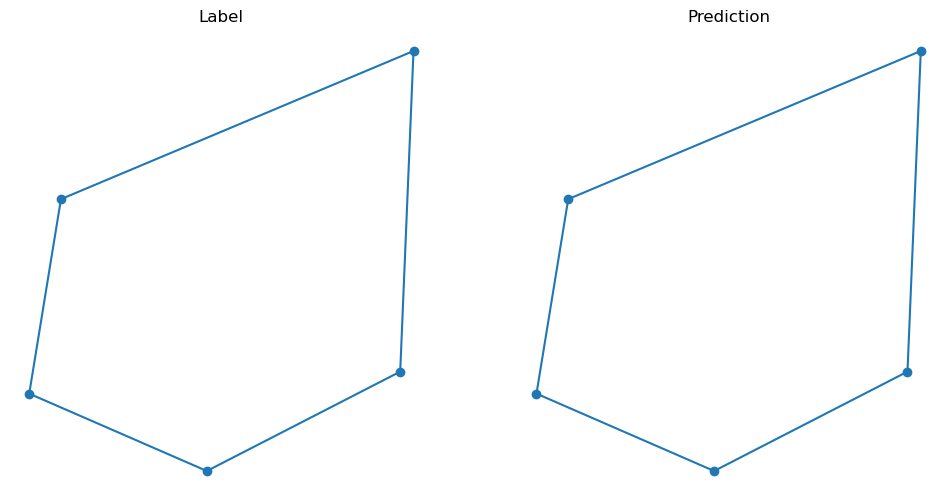

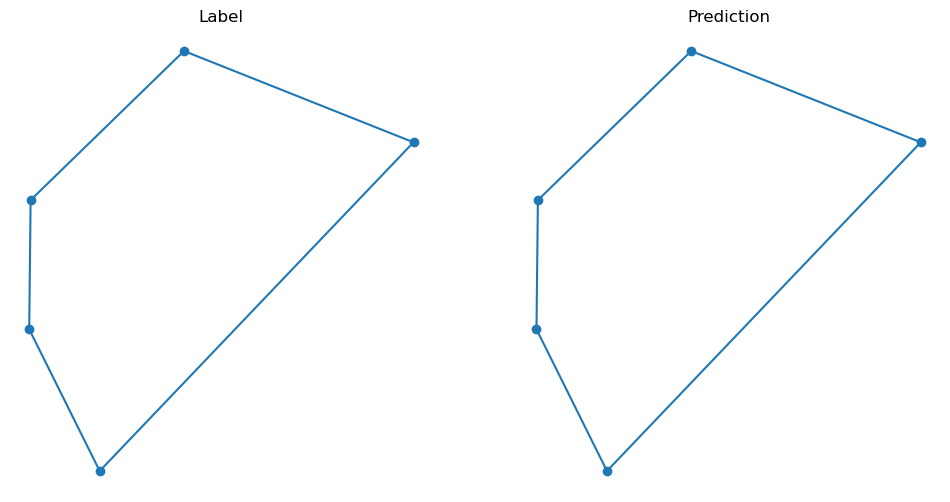

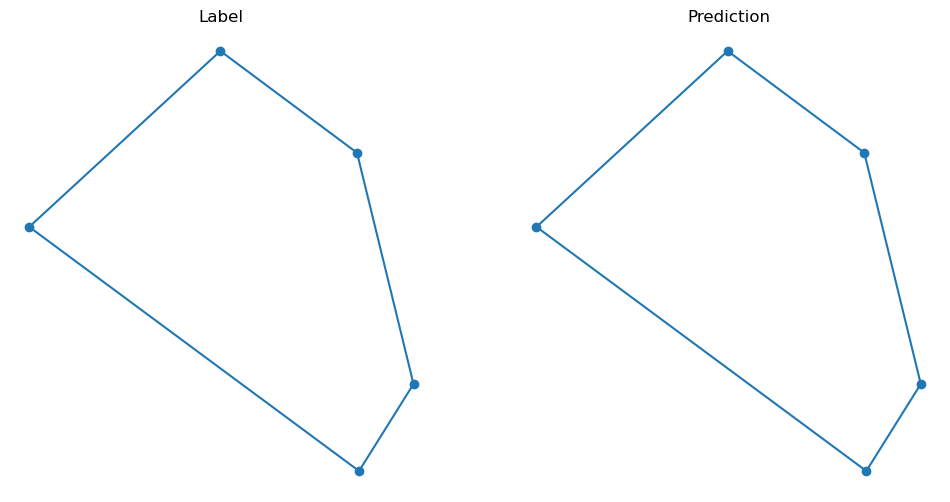

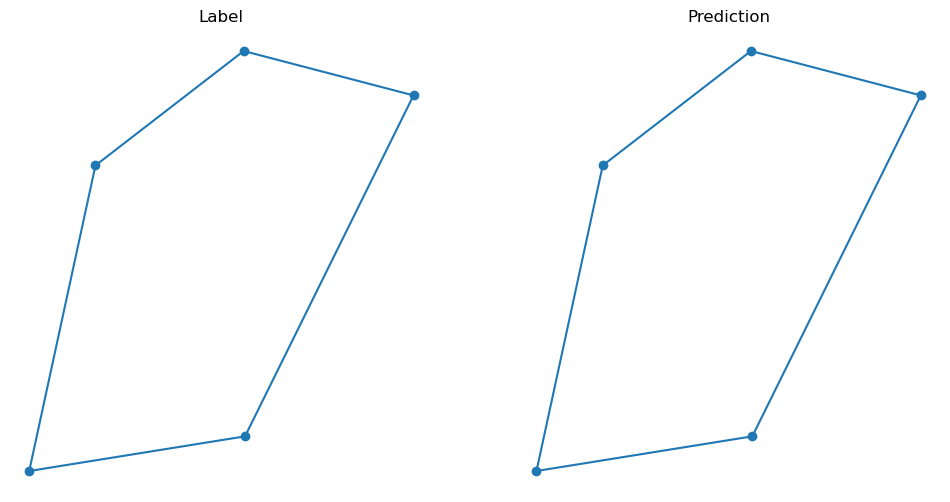

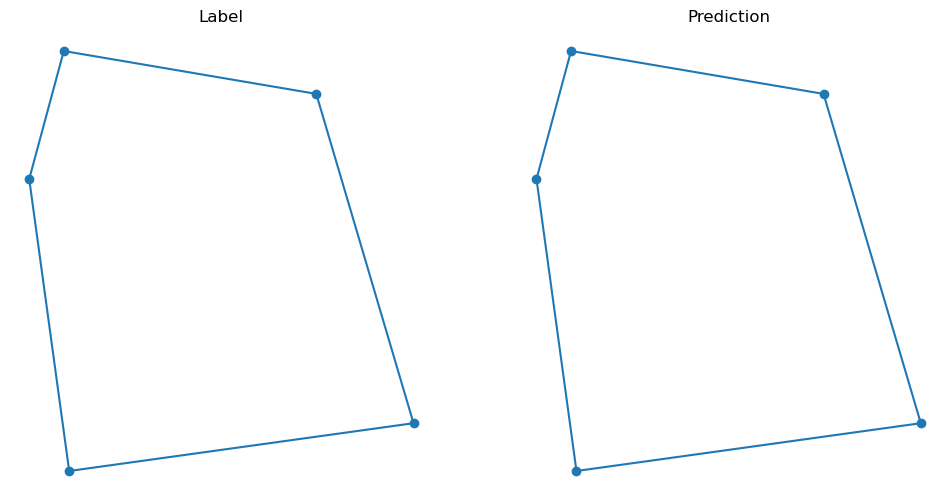

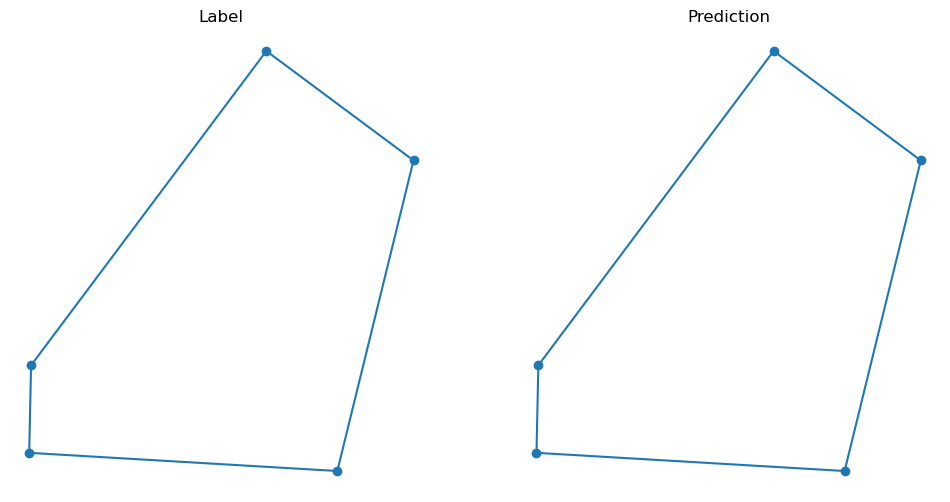

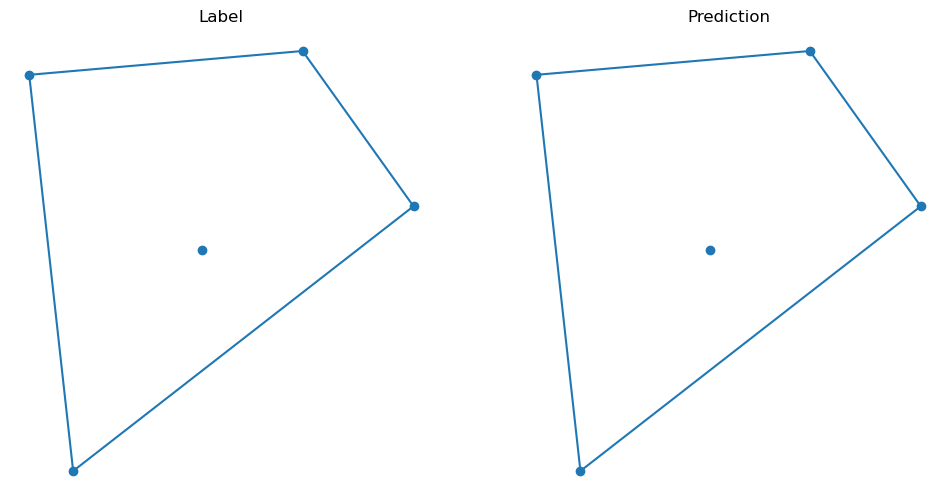

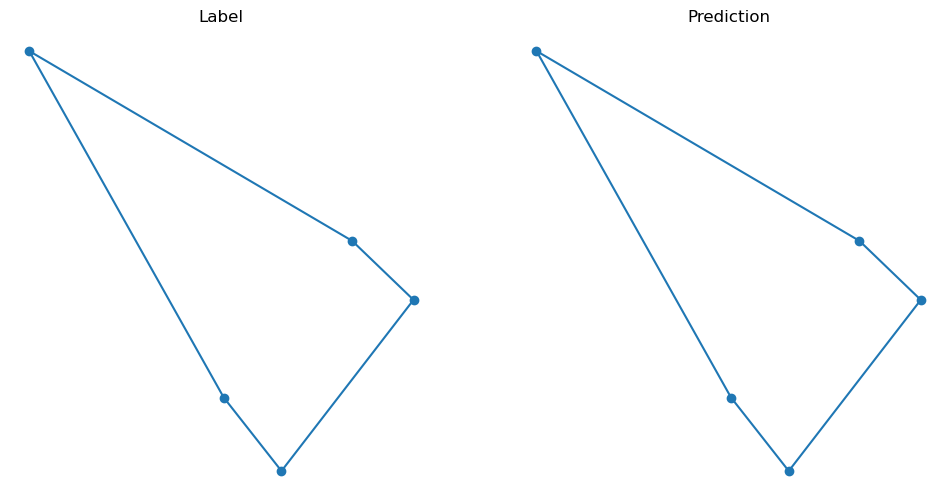

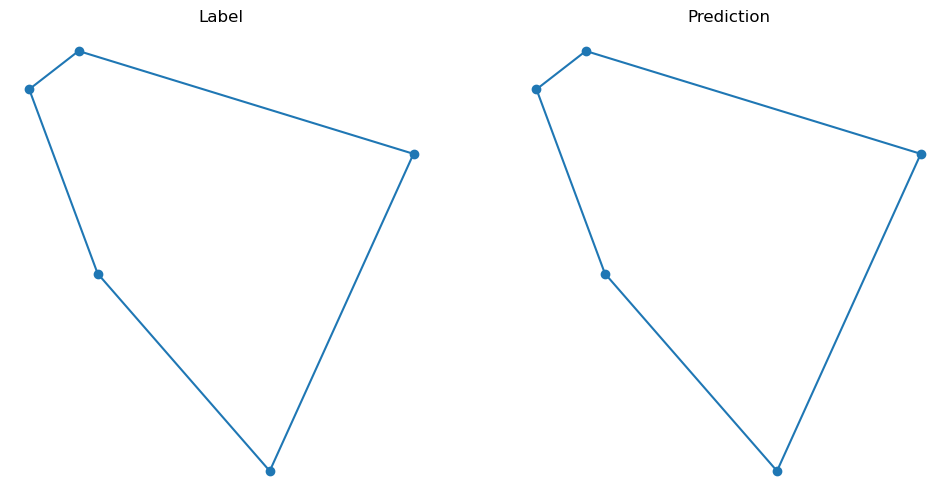

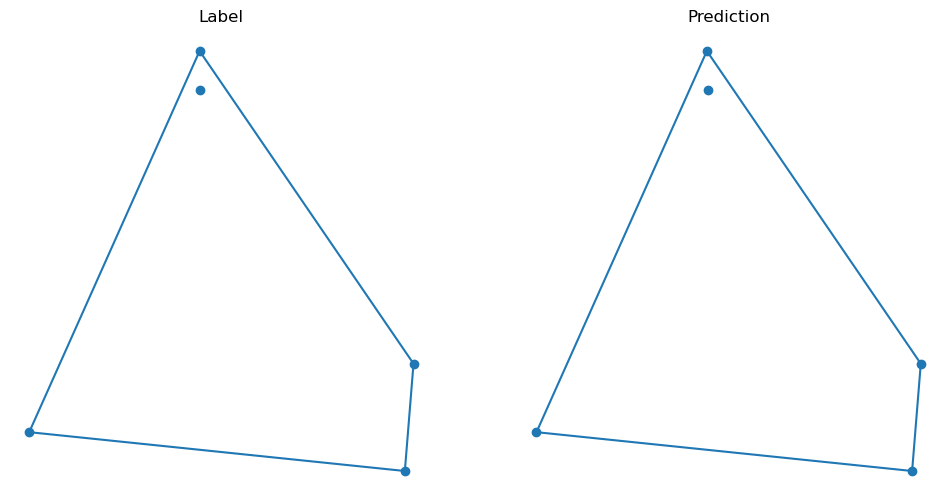

In [23]:
#draw convex hull

n_samples = 10

predictions, _ = PN.eval(val_inputs[:n_samples], val_labels[:n_samples])

for i in range(n_samples):
  plot_convex_hull(val_inputs[i], val_labels[i], predictions[i])

# TSP 그리기

In [21]:
import matplotlib.pyplot as plt

def plot_TSP(inp, targ, pred):

  fig = plt.figure(figsize=[12, 6])

  ax = plt.subplot(1, 2, 1)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, targ.shape[0]):
    if targ[mx] == 0:
      mx += -1
      break;

  #print(list(range(mx+1))+[0])
  plt.plot(inp[targ[list(range(mx+1))+[0] ]-1, 0], inp[targ[list(range(mx+1))+[0]]-1, 1])
  
  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Label")

  ax = plt.subplot(1, 2, 2)

  plt.scatter(inp[:, 0], inp[:, 1])

  for mx in range(0, pred.shape[0]):
    if pred[mx] <= 0:
      mx += -1
      break;

  plt.plot(inp[pred[list(range(mx+1))+[0] ]-1, 0], inp[pred[list(range(mx+1))+[0]]-1, 1])

  plt.gca().invert_yaxis()
  plt.axis("off")

  plt.title("Prediction")


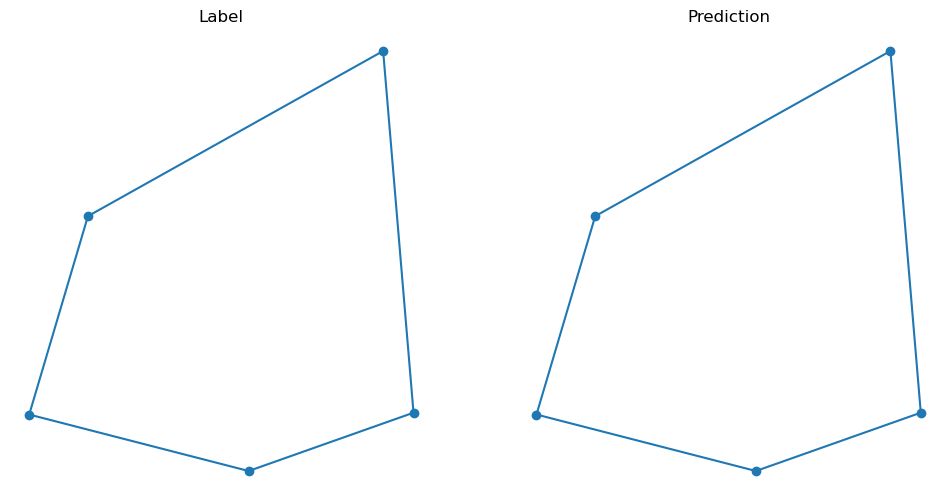

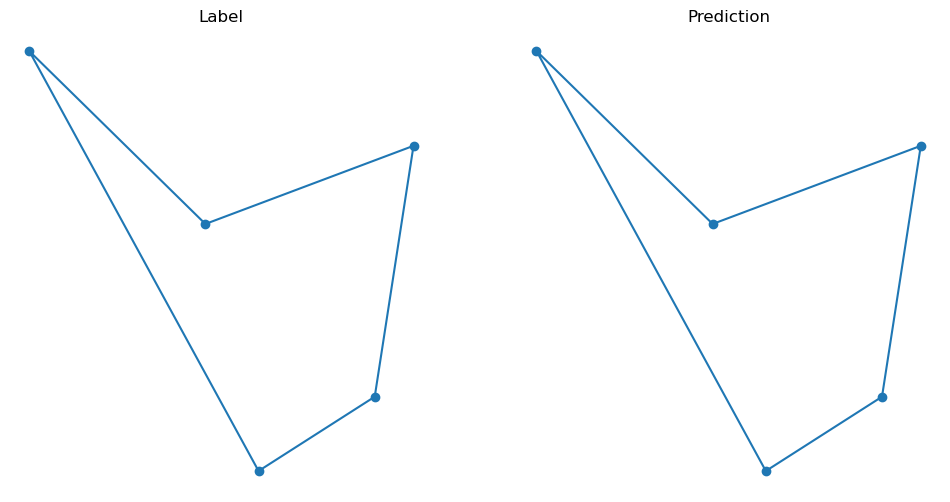

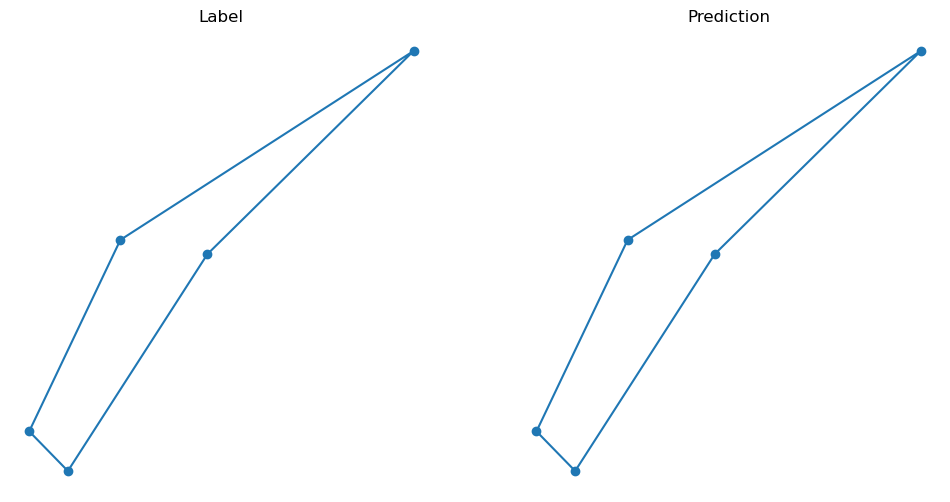

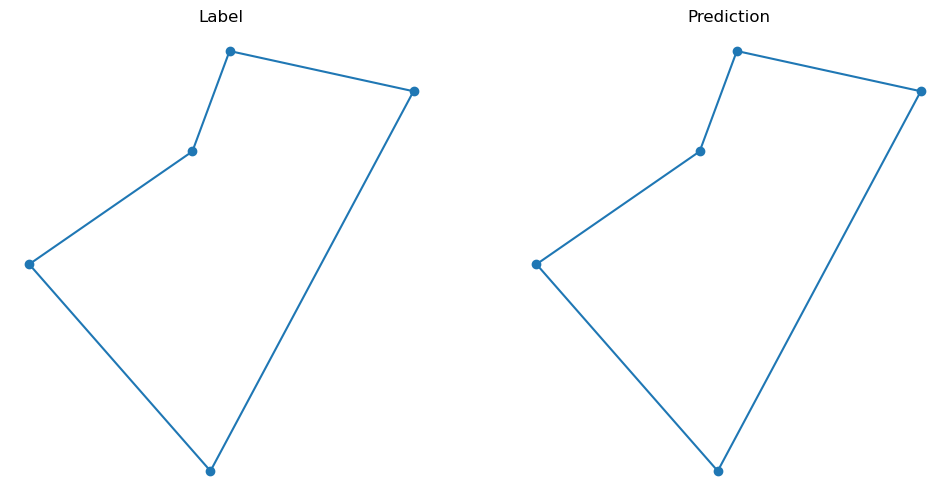

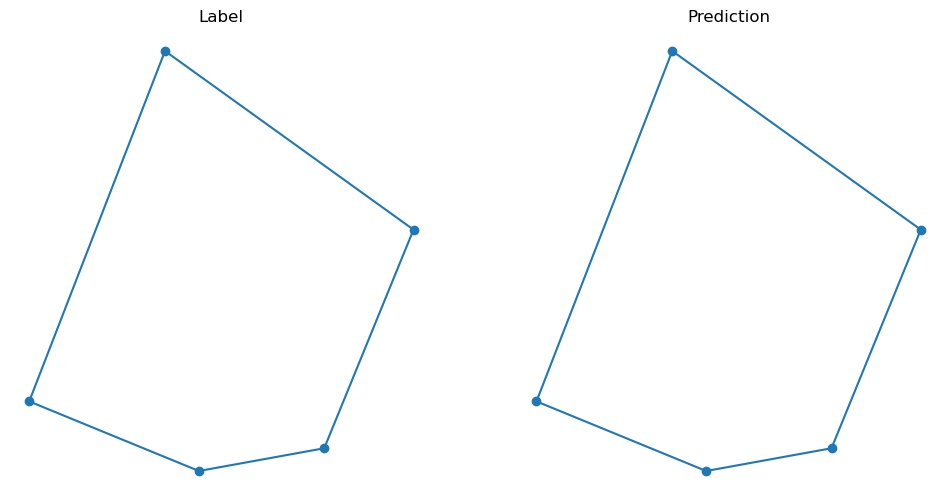

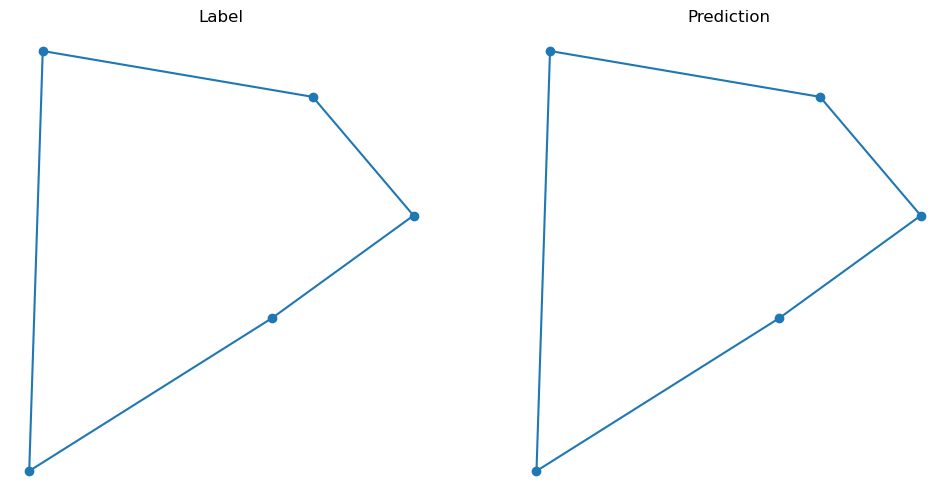

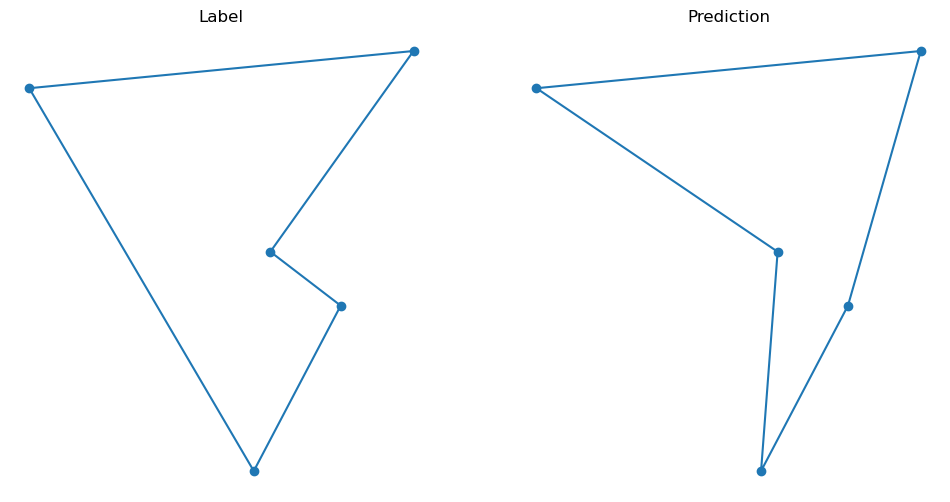

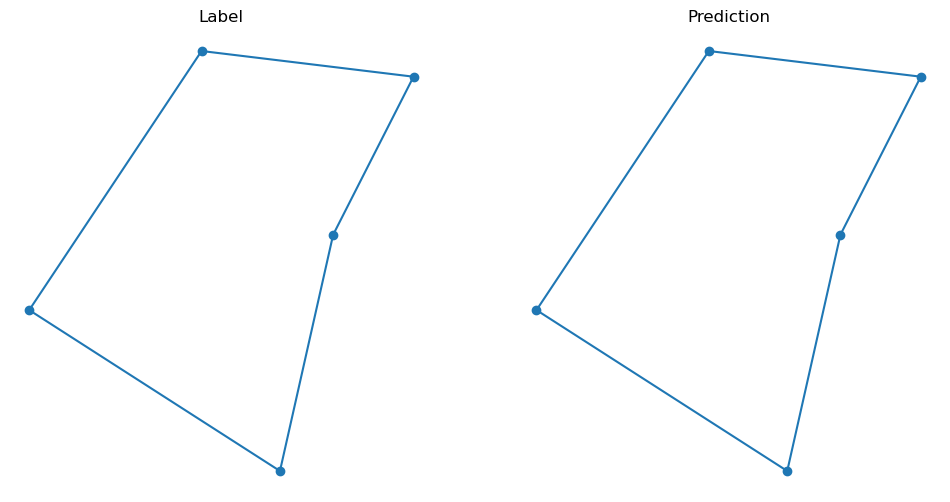

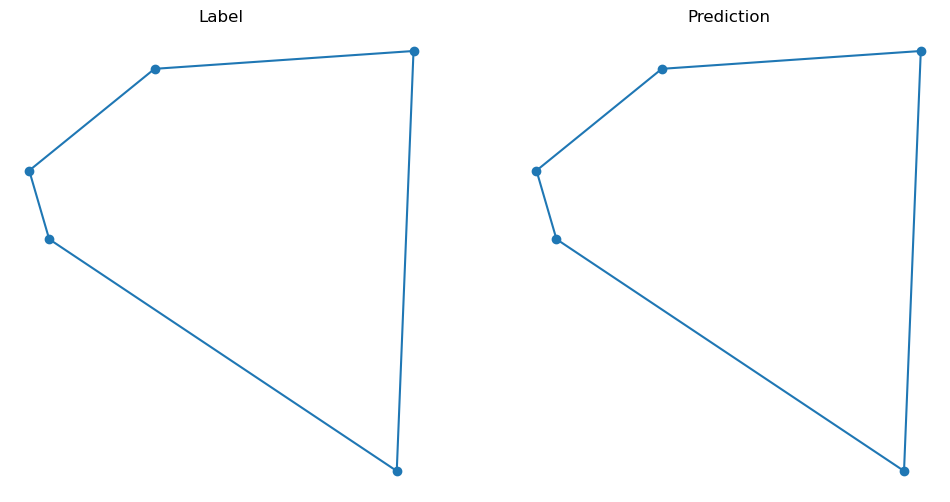

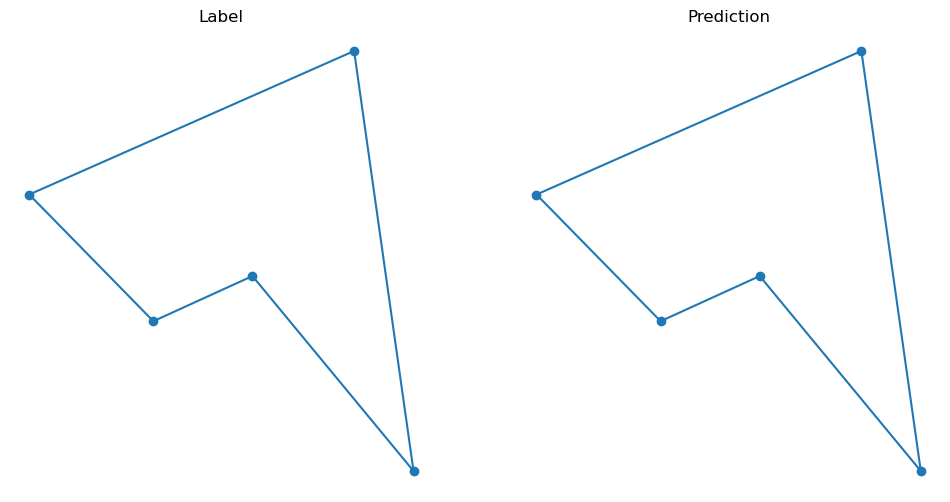

In [22]:
#draw TSP

n_samples = 10

predictions, _ = PN.eval(val_inputs[:n_samples], val_labels[:n_samples])

predictions = predictions.numpy()

for i in range(n_samples):
  plot_TSP(val_inputs[i], val_labels[i], predictions[i])

In [30]:
val_labels[i]

array([2, 1, 4, 5, 3])